### Customer_Data_Preprocessing

_Below is the structured and well-commented code for "Tasks 1 to 3," including:_

- Reading the CSV

- Restructuring to nested dictionaries

- Handling missing dependents


In [1]:
import csv
import json

def process_csv_to_json(csv_file, json_file):
    problematic_rows = []
    data = []
    
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            dependants_value = row['Dependants'].strip()
            if not dependants_value:
                problematic_rows.append(i + 2)
                row['Dependants'] = 0
            else:
                row['Dependants'] = int(dependants_value)
                
            Vehicle = {
                'make': row['Vehicle Make'],
                'model': row['Vehicle Model'],
                'year': int(row['Vehicle Year']),
                'category': row['Vehicle Type']
            }
            credit_card = {
                'start_date': row['Credit Card Start Date'],
                'end_date': row['Credit Card Expiry Date'],
                'number': int(row['Credit Card Number']),
                'ccv': int(row['Credit Card CVV']),
                'iban': row['Bank IBAN']
            }
            address = {
                'street': row['Address Street'],
                'city': row['Address City'],
                'postcode': row['Address Postcode']
            }    
                
                
            customer = {
                'first_name': row['First Name'],
                'second_name': row['Last Name'],
                'age': int(row['Age (Years)']),
                'sex': row['Sex'],
                'retired': row['Retired'].lower() == 'true',
                'marital_status': row['Marital Status'],
                'dependants': row['Dependants'],
                'salary': float(row['Yearly Salary (Dollar)']),
                'pension': float(row['Yearly Pension (Dollar)']),
                'company': row['Employer Company'],
                'commute_distance': float(row['Distance Commuted to Work (Km)']),
                'vehicle': Vehicle,
                'credit_card': credit_card,
                'address': address
                
            }
            
            data.append(customer)
    
    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4)
    
    print("Problematic rows for dependants (CSV row numbers):", problematic_rows)
    return data

csv_file = 'acw_user_data.csv'
processed_json = 'processed.json'
data = process_csv_to_json(csv_file, processed_json)

Problematic rows for dependants (CSV row numbers): [23, 111, 181, 207, 272, 274, 276, 360, 462, 470, 581, 638, 681, 727, 824, 867, 919, 933, 985]


### Filter Retired and Employed Customers into Separate JSON Files


In [2]:
import json

def filter_customers(data):
    retired = [customer for customer in data if customer['retired']]
    employed = [customer for customer in data if customer['company']]
    
    with open('retired.json', 'w') as f:
        json.dump(retired, f, indent=4)
    
    with open('employed.json', 'w') as f:
        json.dump(employed, f, indent=4)

filter_customers(data)

#### Customers with valid, parseable dates that exceed 10 years are included.


In [3]:
from datetime import datetime
import calendar
import json

def should_flag_ccard(customer):
    try:
        # Extract start and end dates from the customer dictionary
        start_date_str = customer['credit_card']['start_date']
        end_date_str = customer['credit_card']['end_date']
        
        # Parse start date as the first day of the month
        start_date = datetime.strptime(start_date_str, "%m/%y")
        
        # Parse end date initially as the first day, then adjust to the last day
        end_date_temp = datetime.strptime(end_date_str, "%m/%y")
        last_day = calendar.monthrange(end_date_temp.year, end_date_temp.month)[1]
        end_date = end_date_temp.replace(day=last_day)
        
        # Calculate the difference in years
        years_diff = (end_date - start_date).days / 365.25
        return years_diff > 10
    except ValueError:
        # Return False if date parsing fails (e.g., invalid format)
        return False

def filter_ccard_issues(data):
    # Filter customers to be flagged
    remove_ccard = [customer for customer in data if should_flag_ccard(customer)]
    
    # Write flagged customers to remove_ccard.json
    with open('remove_ccard.json', 'w') as f:
        json.dump(remove_ccard, f, indent=4)

# Example usage (assuming 'data' is a list of customer dictionaries)
filter_ccard_issues(data)

### Customers with Credit Card Date Issues


In [4]:
from dateutil import parser
import json

def filter_ccard_issues(data):
    remove_ccard = []
    invalid_dates = []
    
    for customer in data:
    
        try:
            start_date = parser.parse(customer['credit_card']['start_date'], dayfirst=True)
            end_date = parser.parse(customer['credit_card']['end_date'], dayfirst=True)
            years_diff = (end_date - start_date).days / 365.25
            if years_diff > 10:
                remove_ccard.append(customer)
        except parser.ParserError:
            invalid_dates.append(customer)
        
    # Save customers with invalid dates for review
    with open('invalid_dates.json', 'w') as f:
        json.dump(invalid_dates, f, indent=4)
    
    print(f"Found {len(invalid_dates)} customers with invalid dates")

filter_ccard_issues(data)

Found 5 customers with invalid dates


### Calculate 'Salary-Commute' Metric and Sort


In [5]:
import json

def calculate_salary_commute(json_file, output_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    for customer in data:
        if customer['commute_distance'] <= 1:
            customer['salary_commute'] = customer['salary']
        else:
            customer['salary_commute'] = customer['salary'] / customer['commute_distance']
    
    data.sort(key=lambda x: x['salary_commute'])
    
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

calculate_salary_commute('processed.json', 'commute.json')

## Data Visualisation


### Calculate Mean Salary and Median Age


In [ ]:
import pandas as pd

df = pd.read_csv('acw_user_data.csv')

mean_salary = df['Yearly Salary (Dollar)'].mean()
median_age = df['Age (Years)'].median()

print("Mean Salary:", mean_salary)
print("Median Age:", median_age)
df

Mean Salary: 57814.078
Median Age: 54.0


### Age Histogram with Bin Width of 5


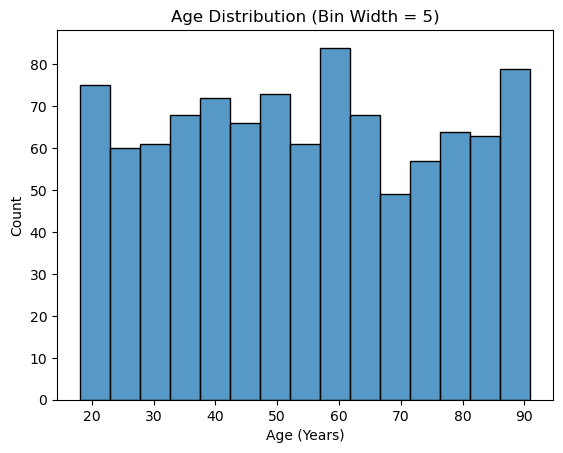

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['Age (Years)'], binwidth=5)
plt.title('Age Distribution (Bin Width = 5)')
plt.show()


### Dependents Histogram, Handling Errors


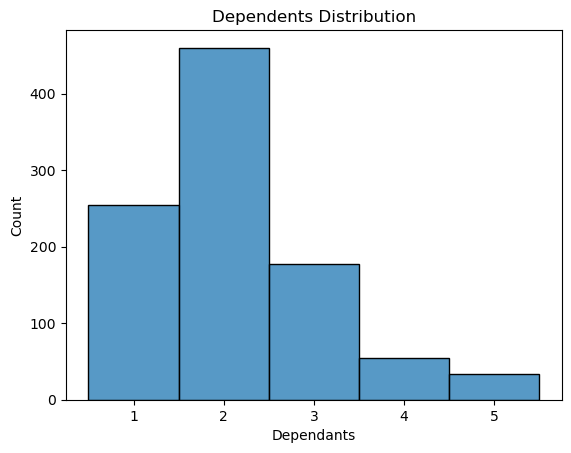

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df['Dependants'] = pd.to_numeric(df['Dependants'], errors='coerce')
sns.histplot(df['Dependants'].dropna(), discrete=True)
plt.title('Dependents Distribution')
plt.show()


### Age Conditioned on Marital Status


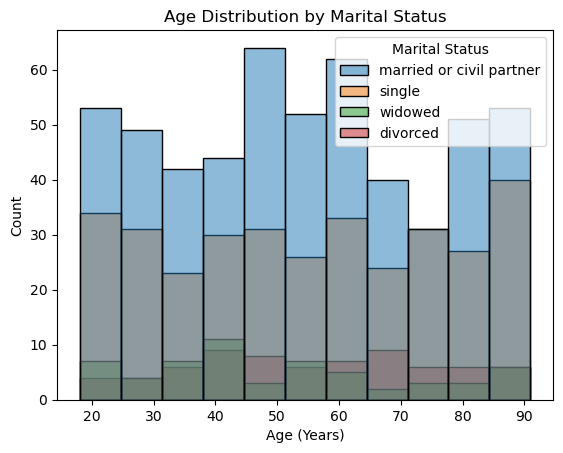

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='Age (Years)', hue='Marital Status')
plt.title('Age Distribution by Marital Status')
plt.show()


### Commute Distance Against Salary


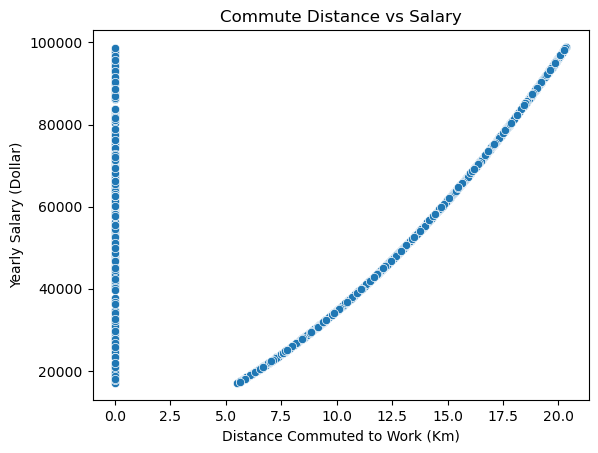

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Distance Commuted to Work (Km)', y='Yearly Salary (Dollar)')
plt.title('Commute Distance vs Salary')
plt.show()


### Age Against Salary


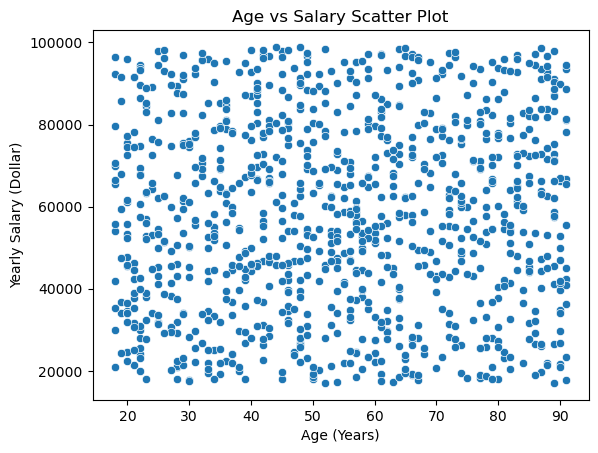

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot of Age vs Salary
sns.scatterplot(data=df, x='Age (Years)', y='Yearly Salary (Dollar)')

# Set plot title
plt.title('Age vs Salary Scatter Plot')

plt.show()

### Age Against Salary Conditioned by Dependents


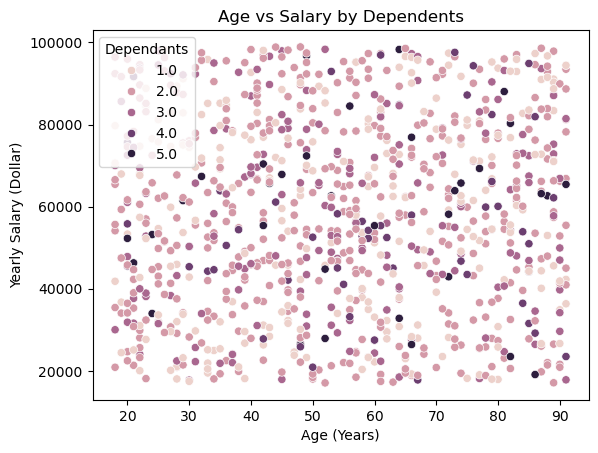

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='Age (Years)', y='Yearly Salary (Dollar)', hue='Dependants')
plt.title('Age vs Salary by Dependents')
plt.show()